# Intro to PyTorch & TorchText

_Main author: Konstantin Todorov_

We used these resources for part of this tutorial:
* https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html
* http://web.stanford.edu/class/cs224n/materials/CS224N_PyTorch_Tutorial.html

This laboratory is meant to teach you about the basics of [PyTorch](https://pytorch.org/), one of the most widely used Python libraries for machine learning. In addition to it, you will learn about [TorchText](https://pytorch.org/text/stable/index.html), one of PyTorch's integrated libraries that is meant to help when training Natural Language Processing (NLP) models. In addition to that, TorchText also provides readily available datasets such as the IMDB one that we will make use of.

At the end of this lab, you will know how to train your own basic model, as well as evaluate and make use of techniques to improve your performance.

In [ ]:
%pylab inline

plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('torch', '1.8.0'),
               ('torchtext', '0.9.0'),
               ('torchvision', '0.9.0'),
               ('matplotlib', '3.0.0'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
#     if module_name == 'scikit-learn':
#         module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)


packages_errors = '\n'.join(packages_errors)

In [ ]:
import torch
import torch.nn as nn

import torchtext

In [ ]:
# We make use of a GPU if one is available on the current system
# Using GPU can make the training process and matrix operations magnitudes faster

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# We set a seed manually for replicability
# This will ensure that every time you run the notebook on the same machine you will receive the same results

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if device == 'cuda':
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(SEED)

## Tensors

Tensors are the most basic building blocks of PyTorch. They are like matrices with extra properties. see here for more: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py.

In [ ]:
# from a list
t = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.long)

In [ ]:
t

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
# from numpy
n = np.ones(5)
t = torch.from_numpy(n)

In [ ]:
t

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)

In [ ]:
# prepoprulated tensors
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [ ]:
# slicing and indexing as in numpy
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [ ]:
# Operations
# This computes the element-wise product
print(f"tensor.mul(tensor) \n {tensor.mul(tensor)} \n")
# Alternative syntax:
print(f"tensor * tensor \n {tensor * tensor}")

tensor.mul(tensor) 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor * tensor 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [ ]:
# This computes the matrix product
print(f"tensor.matmul(tensor.T) \n {tensor.matmul(tensor.T)} \n")
# Alternative syntax:
print(f"tensor @ tensor.T \n {tensor @ tensor.T}")

tensor.matmul(tensor.T) 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 

tensor @ tensor.T 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


In [ ]:
# in place operations require a _ suffix
print(tensor, "\n")
tensor.add_(5)
# same as tensor = tensor.add(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


## A super simple NN

From https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html.

In [ ]:
import torch, torchvision
# load a model, some data and labels
# 45M
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/giovannicolavizza/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
prediction = model(data) # forward pass

In [ ]:
loss = (prediction - labels).sum() # calculates the loss
loss.backward() # backward pass, stores the gradients in each parameter's .grad attribute

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9) # loads an optimizers and passes the models parameters to it

In [ ]:
optim.step() # does one gradient descent step, and that's it!

## Autograd

From: http://web.stanford.edu/class/cs224n/materials/CS224N_PyTorch_Tutorial.html.

Also see: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html. 

In [ ]:
# Create an example tensor
# requires_grad parameter tells PyTorch to store gradients
x = torch.tensor([2.], requires_grad=True)

# Print the gradient if it is calculated
# Currently None since x is a scalar
print(x.grad)

None


In [ ]:
# Calculating the gradient of y with respect to x
y = x * x * 3 # 3x^2
y.backward()
print(x.grad) # d(y)/d(x) = d(3x^2)/d(x) = 6x = 12

tensor([12.])


In [ ]:
# Calculating the gradient of z with respect to x
z = x * x * 3 # 3x^2
z.backward()
print(x.grad)

tensor([24.])


We can see that the `x.grad` is updated to be the sum of the gradients calculated so far. When we run backprop in a neural network, we sum up all the gradients for a particular neuron before making an update. This is also the reason why we need to run `zero_grad()` in every training iteration (more on this later). Otherwise our gradients would keep building up from one training iteration to the other, which would cause our updates to be wrong.

Let us work towards a full model next, and introduce more advanced components.

# Part I: Preparing the data

We will use PyTorch and TorchText to create a **sentiment classifier using the IMDB dataset**. We first load it from the `torchtext.datasets` namespace. For the purpose of testing we can load only the `train` split. Note that different sets have different splits. You can see all available datasets and their properties [here](https://pytorch.org/text/stable/datasets.html#imdb). 

In [ ]:
# 84M
train_imdb_iterator = torchtext.datasets.IMDB(split='train')

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:17<00:00, 4.90MB/s]


Next, let's see what kind of data we are working with. The `train_imdb_iterator` is a python iterator object and as such, we can iterate through it by calling the `next` function for example.

In [ ]:
label, text = next(train_imdb_iterator)

print(f'Text sequence:\n{text}')
print(f'Sentiment: {label}')

Text sequence:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and f

In [ ]:
label, text = next(train_imdb_iterator)

print(f'Text sequence:\n{text}')
print(f'Sentiment: {label}')

Text sequence:
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we're treated to the site of Vincent Gallo's throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, an

As you can see, each element from the dataset contains an IMDB review and a sentiment ground truth label. The label can be either positive (pos) or negative (neg). Our goal is to train a machine learning model which can predict the sentiment of a given text.

In [ ]:
import torchtext.datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from collections import Counter

def get_tokenized_data(tokenizer):
    # takes a tokenizer and returns tokens with counts
    train_iterator = torchtext.datasets.IMDB(split='train')
    
    counter = Counter()
    for (label, line) in train_iterator:
        counter.update(tokenizer(line))
        
    return counter

def build_vocabulary(data_counter, vectors=None):
    # builds a vocabulary using torchtext Vocab
    vocab = torchtext.legacy.vocab.Vocab(data_counter, min_freq=1, vectors=vectors)
    return vocab

In [ ]:
tokenizer = get_tokenizer('basic_english')
data_counter = get_tokenized_data(tokenizer)
vocab = build_vocabulary(data_counter)

In [ ]:
def tokenize_text(text, vocab, tokenizer):
    return [vocab[token] for token in tokenizer(text)]

def tokenize_label(label):
    if label == 'neg':
        return 0
    else:
        return 1

In [ ]:
# example
tokenize_text('here is an example', vocab, tokenizer)

[132, 10, 41, 465]

In [ ]:
# example
tokenize_label('pos')

1

In [ ]:
# Let's see how many unique tokens we have in our vocabularies

print(f"Unique tokens in vocabulary: {len(vocab):,}")

Unique tokens in vocabulary: 100,684


In [ ]:
# We can also check the most common tokens in our vocabulary

print(vocab.freqs.most_common(20))

[('the', 335746), ('.', 327192), (',', 276280), ('and', 163290), ('a', 162473), ('of', 145437), ('to', 135208), ("'", 133857), ('is', 107221), ('it', 96024), ('in', 93307), ('i', 87401), ('this', 75878), ('that', 73153), ('s', 62933), ('was', 48170), ('as', 46807), ('for', 44116), ('with', 44041), ('movie', 43421)]


Vocabularies contain so called **i**ndex **to s**tring vector which is usually represented as a list of string where the index of an element represents the index of this token in the vocabulary. We can access this list in a TorchText data field using the `.itos` property

In [ ]:
print(vocab.itos[:10])

['<unk>', '<pad>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'"]


Similarly, vocabularies also contain the opposite mapping, namely **s**tring **to i**ndex which is a dictionary with the keys being the tokens and the values - the corresponding vocabulary indices. This can be examined using the `.stoi` property of a TorchText data field.

In [ ]:
print(list(vocab.stoi.items())[:10])

[('<unk>', 0), ('<pad>', 1), ('the', 2), ('.', 3), (',', 4), ('and', 5), ('a', 6), ('of', 7), ('to', 8), ("'", 9)]


The next step is to create a set of data loaders which organise our data into batches of datapoints, each contained into a tensor.

In [ ]:
from torch.utils.data import DataLoader

def collate_batch(batch, vocab, tokenizer):
    # takes a batch of data, a vocabulary and tokenizers, and creates a tensor representation doing padding where needed
    batch_size = len(batch)
    label_list, text_list = [], []
    
    # Tokenize labels and texts
    for (label, text) in batch:
        label_list.append(tokenize_label(label))
        tokenized_text = tokenize_text(text, vocab, tokenizer)
        text_list.append(tokenized_text)

    # Put all texts into a single numpy array of uniform length
    # For all sequences that are shorther than the maximum length, pad to the right with 0
    lengths = [len(text) for text in text_list]
    max_length = max(lengths)
    padded_sequences = np.zeros((batch_size, max_length), dtype=np.int64)
    for i, (length, text) in enumerate(zip(lengths, text_list)):
        padded_sequences[i][0:length] = text_list[i][0:length]
        
    # Finally transform the arrays into tensors and return to the dataloader
    label_tensor = torch.tensor(label_list, dtype=torch.float32).to(device)
    sequences_tensor = torch.from_numpy(padded_sequences).to(device)
    return sequences_tensor, label_tensor

In [ ]:
from torch.utils.data.dataset import random_split

def get_dataloaders(batch_size, vocab, tokenizer):
    # collates the data and puts it into a data loader
    
    train_iter, test_iter = torchtext.datasets.IMDB()
    train_dataset, test_dataset = list(train_iter), list(test_iter)
    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = random_split(
        train_dataset,
        [num_train, len(train_dataset) - num_train])
    
    train_dataloader = DataLoader(
        split_train_,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda x: collate_batch(x, vocab, tokenizer))
    
    valid_dataloader = DataLoader(
        split_valid_,
        batch_size=batch_size,
        collate_fn=lambda x: collate_batch(x, vocab, tokenizer))
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        collate_fn=lambda x: collate_batch(x, vocab, tokenizer))

    return train_dataloader, valid_dataloader, test_dataloader

In [ ]:
BATCH_SIZE = 128

train_dataloader, valid_dataloader, test_dataloader = get_dataloaders(BATCH_SIZE, vocab, tokenizer)

# Part II: The model

### nn.Module vs nn.functional

The `torch.nn.Module` or simply `nn.Module` is arguably one of the most important parts and what many refer to as the "cornerstone" of PyTorch. In order to build a machine learning model that is able to backpropagate automatically, one must define an `nn.Module` object and then invoke its `forward` method to run it. This is the Object Oriented way of doing things. On the other hand, people also make use of `nn.functional` which provides some layers/activations in the form of functions that can be directly called on the input rather than defining the an object. For example, in order to rescale an image tensor, you call `nn.functional.interpolate` on an image tensor.

### Understanding stateful-ness

Normally, any layer can be seen as a function. For example, a convolutional operation is just a bunch of multiplication and addition operations. So, it makes sense for us to just implement it as a function right? But wait, the layer holds weights which need to be stored and updated while we are training. Therefore, from a programmatic angle, a layer is more than function. It also needs to hold data (weights), which change as we train our network.

It must be understood that the data held by the convolutional layer **changes**. This means that the layer has a state which changes as we train. For us to implement a function that does any operation, we would also need to define a data structure to hold the weights of the layer separately from the function itself. And then, make this external data structure an input to our function. Or we could just define a class to hold the data structure, and make convolutional operation as an member function. This would really ease up our job, as we don't have to worry about stateful variables existing outside of the function. 

This all seems rather complicated, but thankfully PyTorch comes to the rescue by exposing the `nn.Module` objects where we have weights or other pre-defined states which define the behaviour of the layers. In the cases where no state or weights are required, one could use the nn.functional, examples being resizing (`nn.functional.interpolate`) or average pooling (`nn.functional.AvgPool2d`).

### nn.Parameter

Before we step towards writing our own model, we must look into one other important part of PyTorch, namely the `nn.Parameter` class. 

Each `nn.Module` has a `parameters()` function which returns its trainable parameters. We have to implicitly define what these parameters are. However, when we use internal `nn.Module` objects, all of the module training weights are implemented as `nn.Parameter`. If you try to assign a tensor to the `nn.Module` object, it won't show up in the `parameters()` unless you define it as `nn.Parameter` object. This has been done to facilitate scenarios where you might need to cache a non-differentiable tensor.

Let's consider the following example:

In [ ]:
class net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Linear(10,5)
        self.tens = torch.ones(3,4)
    
    def forward(self, x):
        return self.linear(x)

##########################################################

class net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Linear(10,5) 
        self.tens = nn.Parameter(torch.ones(3,4))
    
    def forward(self, x):
        return self.linear(x)

##########################################################

class net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Linear(10,5)
        self.net  = net2()

    def forward(self, x):
        return self.linear(x)

Having defined those simple networks, let's invoke the `named_parameters` function of each. This calls the `parameters` function and also returns the name of each parameter. Notice how the parameters differ across the three networks.

In [ ]:
def print_named_parameters(model):
    for name, parameter in model.named_parameters():
        print(f' ** {name}: {parameter}')
    
print('# Net 1:')
print_named_parameters(net1())

print('\n# Net 2:')
print_named_parameters(net2())

print('\n# Net 3:')
print_named_parameters(net3())

# Net 1:
 ** conv.weight: Parameter containing:
tensor([[ 0.2718,  0.1165,  0.1383, -0.1757,  0.0886,  0.0415,  0.2994, -0.2252,
          0.0365,  0.1212],
        [-0.0201, -0.2129,  0.1633, -0.2027, -0.2562, -0.0417, -0.1582, -0.2581,
         -0.1789,  0.1360],
        [ 0.1099,  0.2290, -0.2491,  0.1853, -0.0509,  0.2958,  0.1447,  0.2031,
          0.2510,  0.1785],
        [ 0.3085,  0.1068, -0.0279,  0.1930, -0.3132, -0.2018,  0.0512,  0.0253,
          0.2034, -0.2902],
        [ 0.3150, -0.0549,  0.0293,  0.1395, -0.0781,  0.0798,  0.1646, -0.2603,
          0.1447,  0.0493]], requires_grad=True)
 ** conv.bias: Parameter containing:
tensor([ 0.0336, -0.2970, -0.0305, -0.2056, -0.2913], requires_grad=True)

# Net 2:
 ** tens: Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)
 ** conv.weight: Parameter containing:
tensor([[ 0.2052,  0.1945, -0.2798,  0.1627, -0.1865, -0.1522,  0.1489,  0.1266,
         -0.17

## Defining a "real" model

Now it's time to define our own PyTorch model which we will train on sentiment analysis detection over the IMDB dataset. 

We will use the model defined in this example
![Sentiment analysis model](https://pytorch.org/tutorials/_images/text_sentiment_ngrams_model.png "Sentiment analysis model") 
\[[reference](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html#define-the-model)\]

For simplicity, we will not use an embedding bag but rather a simple embedding layer. This is the first inner module we define. It uses `input_dimension` and `embedding_dimension` arguments that can differ based on our use case or experiment. Afterwards, a fully connected linear layer maps down the `embedding_dimension` to an `output_dimension` which in our case would be 1 as we have two labels which can be either 0 or 1.

We also add a uniform weight initialization. Appropriate initialization can often improve and/or speed up the training process. We also add an optional embeddings weight initialization from an external source (more on this later).

Finally, the forward iteration must be implemented. First, a pass through the embedding layer must be performed before taking the average value of the embeddings. Finally, the output must be mapped down using the fully connected layer.

In [ ]:
class SentimentAnalysisModel(nn.Module):
    def __init__(
        self,
        input_dimension,
        embedding_dimension,
        output_dimension,
        pretr_embeddings=None):
        super().__init__()

        self._embedding_layer = nn.Embedding(input_dimension, embedding_dimension)    
        self._fully_connected_layer = nn.Linear(embedding_dimension, output_dimension)
        self._init_weights(pretr_embeddings)
    
    # Use uniform initialization of the weights
    def _init_weights(self, pretr_embeddings):
        initrange = 0.5
        
        # We add an option to initialize the embeddings from external source
        if pretr_embeddings is not None:
            self._embedding_layer.weight.data.copy_(pretr_embeddings)
        else:
            self._embedding_layer.weight.data.uniform_(-initrange, initrange)

        self._fully_connected_layer.weight.data.uniform_(-initrange, initrange)
        self._fully_connected_layer.bias.data.zero_()

    def forward(self, input_batch):
        # Process the input batch and return a result that can be processed from the loss function
        # input_batch is of shape [ batch_size x max_length ]
        
        embeddings = self._embedding_layer.forward(input_batch)
        # embeddings are of shape [ batch_size x max_length x embedding_dimension ]
        
        embeddings_mean = embeddings.mean(dim=1)
        # embeddings_mean is now [ batch_size x embedding_dimension ]
        
        result = self._fully_connected_layer.forward(embeddings_mean)
        # finally, our result is [ batch_size x 1 ]
        
        return result

In [ ]:
INPUT_DIMENSION = len(vocab)
EMBEDDING_DIMENSION = 300
OUTPUT_DIMENSION = 1

# We can now initialize our model. Note the .to(device) part. 
# This transfers the model to the previously defined device (could be a GPU) for faster computation.

model = SentimentAnalysisModel(
    INPUT_DIMENSION, 
    EMBEDDING_DIMENSION, 
    OUTPUT_DIMENSION).to(device)

In [ ]:
# We can now check how our model looks like
print(model)

SentimentAnalysisModel(
  (_embedding_layer): Embedding(100684, 300)
  (_fully_connected_layer): Linear(in_features=300, out_features=1, bias=True)
)


After we have the model, we must define a loss function. Here, we will make use of the [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) defined in PyTorch. This loss combines a Sigmoid layer and the Binary Cross Entropy Loss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.

In [ ]:
criterion = nn.BCEWithLogitsLoss().to(device)

The next simple example shows how we use our loss function during training. 

Our model outputs a prediction for each entry (the logit, or the log-odds, modelled as a linear combination of the inputs). Let's assume we have three elements in our dataset. As our task is a binary classification one, our model outputs a value which is then transformed into a probability (value between 0 and 1) using a sigmoid function. See more [here](https://en.wikipedia.org/wiki/Logistic_regression).

On the other side, our targets are usually integers. In the case of binary classification, they can be only 0 or 1. For the purpose of comparison with the probabilities which are floats, we use float type for the labels too. 

Finally, we pass the model output and the original targets to the loss function which computes a number that is our loss. The lower and closer to 0 the loss value is, the better are our model predictions resembling the true labels. 

During training, we must also call the `.backward()` function of the loss result in order to back-propagate through the model and update our weights. 

_Note: Execute the next cell multiple times to see how the loss changes depending on the different targets and model outputs_

In [ ]:
model_output = torch.randn(3)
print(f'Model output: {model_output}')
target = torch.empty(3).random_(2)
print(f'Target: {target}')
test_criterion = nn.BCEWithLogitsLoss()
output = test_criterion.forward(model_output, target)
print(f'Calculated loss: {output}')

Model output: tensor([1.7029, 0.6236, 0.5424])
Target: tensor([1., 0., 1.])
Calculated loss: 0.5594732165336609


Finally, a `torch.optim` optimizer must be defined. This is used to traverse through the parameter space and find the optimal weights for the model. The [`Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimizer is a solid choice. Stick to the default arguments. Later, you can experiment with different learning rates that can change the training process.

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

Before we go to the training process, we must prepare a function that can calculate the accuracy of the model. Due to the nature of the training, our model is outputting raw predictions while we also have ground truth values. These are both in the forms of vectors, although the predictions could be float numbers while the true values are usually integers.

We then implement a function which takes these two vectors and calculates a value between 0 and 1 which corresponds to the accuracy. Even more so, we are working with batches and therefore have vectors of such values, e.g. if we have predicted [0, 1, 0, 1] and the ground truth is [1, 1, 1, 1], then the function should output 0.5. Keep in mind that the `calculate_accuracy` function accepts and works with tensors and not regular lists.

In [ ]:
def calculate_accuracy(predictions, ground_truth):
    # Returns accuracy per batch
    
    # transform the predictions into probabilities
    predictions = torch.sigmoid(predictions)
    
    # round the predictions into integers
    rounded_predictions = torch.round(predictions)
    
    # compare which of the predictions are equal to their corresponding true value
    correct = (rounded_predictions == ground_truth).float()
    
    # take the average for all elements in one batch
    accuracy = correct.sum() / len(correct)
    return accuracy

# Part III: Training

We can now proceed to training our model. 

First you will see the `zero_optimizer_gradients` function. This is necessary during training to avoid problems with gradients accumulating. We usually execute this before we backpropagate to avoid using gradients from previous steps (see above, Autograd, for a simple example).

In [ ]:
def zero_optimizer_gradients(optimizer):
    optimizer.zero_grad()

We now proceed to the training process. We define one _epoch_ to be the period where we iterate over **all** elements (or batches) in our dataset. Usually, during training we can iterate over many epochs until we are comfortable with our results. Starting, with the smallest iteration, we a function which works on batch-level. The most important steps during one such pass are:
* Perform a forward pass through the model
* Perform a forward pass through the loss function using the predicted labels from the model
* Calculate the accuracy by comparing the predictions and the ground truth

This function can be used both during training (when we update the parameters of the network) and during evaluation (where we only want to predict labels). To distinguish the two modes, we use the `eval_mode` argument. When we are training (i.e. `eval_mode == False`) we must perform a backpropagation from the loss function and perform a step in the parameter space using the optimizer

In [ ]:
def perform_batch_iteration(
    batch,
    model,
    criterion,
    optimizer,
    eval_mode):

    if not eval_mode:
        # reset gradients
        zero_optimizer_gradients(optimizer)
    
    text, label = batch
    
    predictions = model.forward(text).squeeze(1)
    loss = criterion.forward(predictions, label)
    accuracy = calculate_accuracy(predictions, label)

    if not eval_mode:
        loss.backward()
        optimizer.step()

    return loss.item(), accuracy.item()

Having passed through one bach, we then define a function which takes care for a whole epoch iteration. In one epoch, we must process _all_ batches of our data and save the loss and accuracy values that we compute for each batch.

In [ ]:
def perform_epoch_iteration(
    model,
    dataloader,
    criterion,
    optimizer,
    eval_mode):
    
    epoch_losses = []
    epoch_accuracies = []
    
    if not eval_mode:
        model.train()
    else:
        model.eval()

    for batch in dataloader:
        loss, accuracy = perform_batch_iteration(batch, model, criterion, optimizer, eval_mode)
        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

    return np.mean(epoch_losses), np.mean(epoch_accuracies)

Finally, for the full training process, we perform multiple epoch iterations for both the training and the validation datasets. We keep the best validation score as a reference. In practice, one must keep reference to the model state and best validation results at the time but for simplicity reasons we skip this.

_Note: As an optional exercise, you can try to define your own `train_model_v2` function where you do this._

In [ ]:
def train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs):
    print('Starting training...')
    
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    for epoch in range(epochs):
        
        # iterate over the train data
        loss, accuracy = perform_epoch_iteration(
            model,
            train_dataloader,
            criterion,
            optimizer,
            eval_mode=False)

        # store the train loss and accuracy for later
        train_losses.append(loss)
        train_accuracies.append(accuracy)
        
        print(f'Epoch: {epoch:02}')
        print(f'\tTrain Loss: {loss:.3f} | Train Acc: {accuracy*100:.2f}%', end='')
        
        # iterate over the train data
        valid_loss, valid_accuracy = perform_epoch_iteration(
            model,
            valid_dataloader,
            criterion,
            None,
            eval_mode=True)

        # store the train loss and accuracy for later
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f'| Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_accuracy*100:.2f}%')
            
    # finally, return the stored lists
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [ ]:
# train the model

N_EPOCHS = 10

train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(
    model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    N_EPOCHS)

Starting training...
Epoch: 00
	Train Loss: 0.661 | Train Acc: 66.32%| Valid Loss: 0.629 | Valid Acc: 76.87%
Epoch: 01
	Train Loss: 0.598 | Train Acc: 77.86%| Valid Loss: 0.576 | Valid Acc: 79.76%
Epoch: 02
	Train Loss: 0.543 | Train Acc: 80.93%| Valid Loss: 0.527 | Valid Acc: 83.14%
Epoch: 03
	Train Loss: 0.489 | Train Acc: 84.86%| Valid Loss: 0.484 | Valid Acc: 83.79%
Epoch: 04
	Train Loss: 0.441 | Train Acc: 86.94%| Valid Loss: 0.445 | Valid Acc: 86.46%
Epoch: 05
	Train Loss: 0.396 | Train Acc: 88.62%| Valid Loss: 0.413 | Valid Acc: 87.21%
Epoch: 06
	Train Loss: 0.362 | Train Acc: 89.57%| Valid Loss: 0.388 | Valid Acc: 87.99%
Epoch: 07
	Train Loss: 0.331 | Train Acc: 90.60%| Valid Loss: 0.368 | Valid Acc: 88.25%
Epoch: 08
	Train Loss: 0.305 | Train Acc: 91.30%| Valid Loss: 0.351 | Valid Acc: 88.22%
Epoch: 09
	Train Loss: 0.283 | Train Acc: 91.96%| Valid Loss: 0.340 | Valid Acc: 89.06%


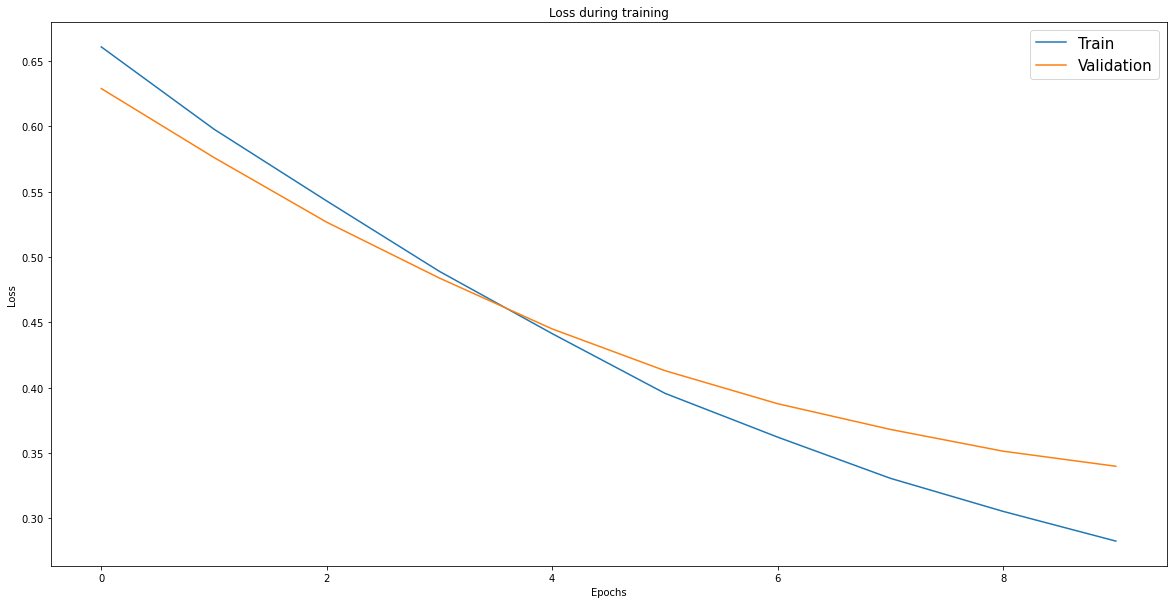

In [ ]:
# Let's compare the train and validation losses and how they changed during the different epochs

plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=15)
plt.show()

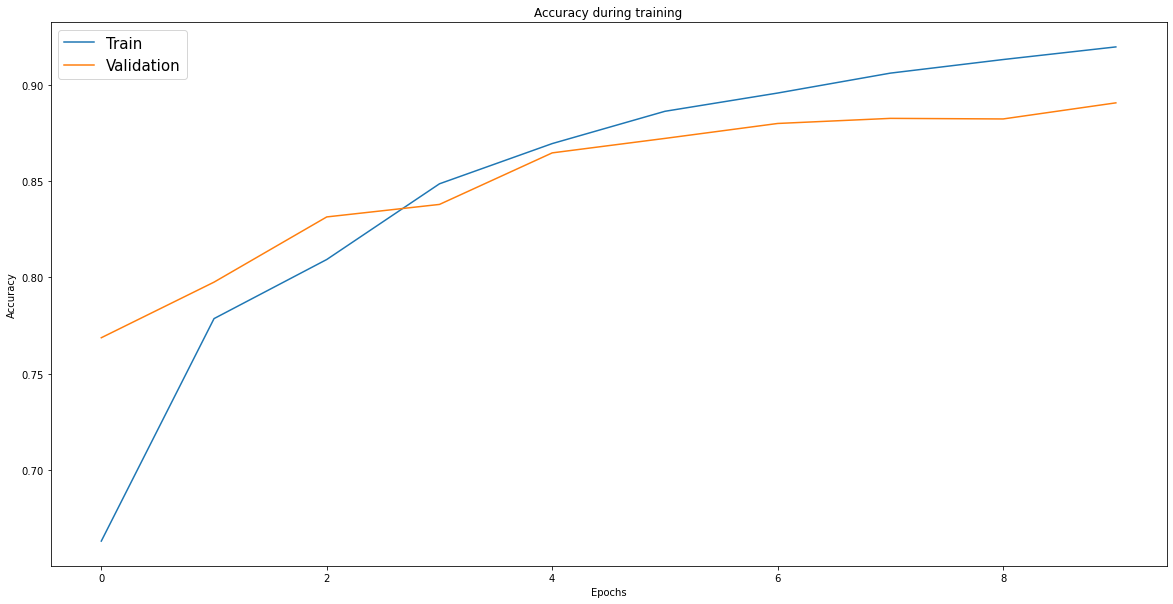

In [ ]:
# We can do the same thing with the accuracy

plt.plot(train_accuracies, label='Train')
plt.plot(valid_accuracies, label='Validation')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=15)
plt.show()

You can see that as training progresses, the performance over the validation dataset stops improving as much. If we continue to train, we risk overfitting. This is what happens when our model learns the training data too well and starts forgetting about generic features that are required when dealing with unseen data (which is the case with the validation data). This is something that we must be careful about in practice as it can prevent us from applying our model on actual real world problems.

In [ ]:
# After we have fully trained our model,
# we can let it run over the test data and check the results that we receive

test_loss, test_acc = perform_epoch_iteration(model, test_dataloader, criterion, None, True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.347 | Test Acc: 87.44%


# Part IV: Pre-trained embeddings

In recent years, pre-trained embeddings have emerged as a very powerful tool for quickly optimizing the training process. When you define an embedding layer simply as it is, its weights are initialized _randomly_. This means that in order to learn which words are contextually close to one another, we must train the model from scratch, often for long periods of time. To overcome this limitation, pre-trained embeddings can be used. If we replace the randomly initialized embeddings with ones that have already been trained in another model, then we might gain some benefits and saving time/compute. 

As a starting point, we use GloVe which comes built in TorchText. They can be accessed using the `vectors` argument during building the vocabulary. The most commonly used GloVe vectors are `glove.6B.300d` meaning that they have been trained on 6 billion tokens and have dimensionality of 300.

In [ ]:
# Watch out: 862M
# Let's build a new vocabulary, this time using pre-trained vectors
pretr_vocab = build_vocabulary(data_counter, vectors='glove.6B.300d')

.vector_cache/glove.6B.zip: 862MB [02:46, 5.19MB/s]                               
100%|█████████▉| 399999/400000 [00:40<00:00, 9924.88it/s] 


In [ ]:
# Build dataloaders, this time using the new vocabulary
pretr_train_dataloader, pretr_valid_dataloader, pretr_test_dataloader = \
    get_dataloaders(BATCH_SIZE, pretr_vocab, tokenizer)

In [ ]:
# We define a new SentimentAnalysisModel, this time using pretrained embeddings
pretr_model = SentimentAnalysisModel(
    INPUT_DIMENSION,
    EMBEDDING_DIMENSION, 
    OUTPUT_DIMENSION,
    pretr_embeddings=pretr_vocab.vectors).to(device)

pretr_optimizer = torch.optim.Adam(pretr_model.parameters())
pretr_criterion = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Train the new model with pre-trained embeddings
(pretr_train_losses, pretr_train_accuracies, 
 pretr_valid_losses, pretr_valid_accuracies) = train_model(
    pretr_model,
    pretr_train_dataloader,
    pretr_valid_dataloader,
    pretr_criterion,
    pretr_optimizer,
    N_EPOCHS)

Starting training...
Epoch: 00
	Train Loss: 0.662 | Train Acc: 66.18%| Valid Loss: 0.627 | Valid Acc: 74.57%
Epoch: 01
	Train Loss: 0.574 | Train Acc: 78.95%| Valid Loss: 0.542 | Valid Acc: 80.59%
Epoch: 02
	Train Loss: 0.482 | Train Acc: 84.85%| Valid Loss: 0.468 | Valid Acc: 83.94%
Epoch: 03
	Train Loss: 0.401 | Train Acc: 87.97%| Valid Loss: 0.411 | Valid Acc: 86.46%
Epoch: 04
	Train Loss: 0.341 | Train Acc: 89.92%| Valid Loss: 0.372 | Valid Acc: 87.42%
Epoch: 05
	Train Loss: 0.298 | Train Acc: 91.40%| Valid Loss: 0.350 | Valid Acc: 87.60%
Epoch: 06
	Train Loss: 0.263 | Train Acc: 92.16%| Valid Loss: 0.327 | Valid Acc: 88.13%
Epoch: 07
	Train Loss: 0.236 | Train Acc: 93.10%| Valid Loss: 0.312 | Valid Acc: 88.71%
Epoch: 08
	Train Loss: 0.213 | Train Acc: 93.86%| Valid Loss: 0.303 | Valid Acc: 88.79%
Epoch: 09
	Train Loss: 0.194 | Train Acc: 94.55%| Valid Loss: 0.295 | Valid Acc: 88.90%


In [ ]:
# Same as before, we perform an epoch iteration over the test dataset 
pretr_test_loss, pretr_test_acc = perform_epoch_iteration(
    pretr_model,
    pretr_test_dataloader,
    pretr_criterion,
    None,
    True)

# Print the results. Are those better than the non-pretrained ones?
print(f'Test Loss: {pretr_test_loss:.3f} | Test Acc: {pretr_test_acc*100:.2f}%')

Test Loss: 0.296 | Test Acc: 88.91%


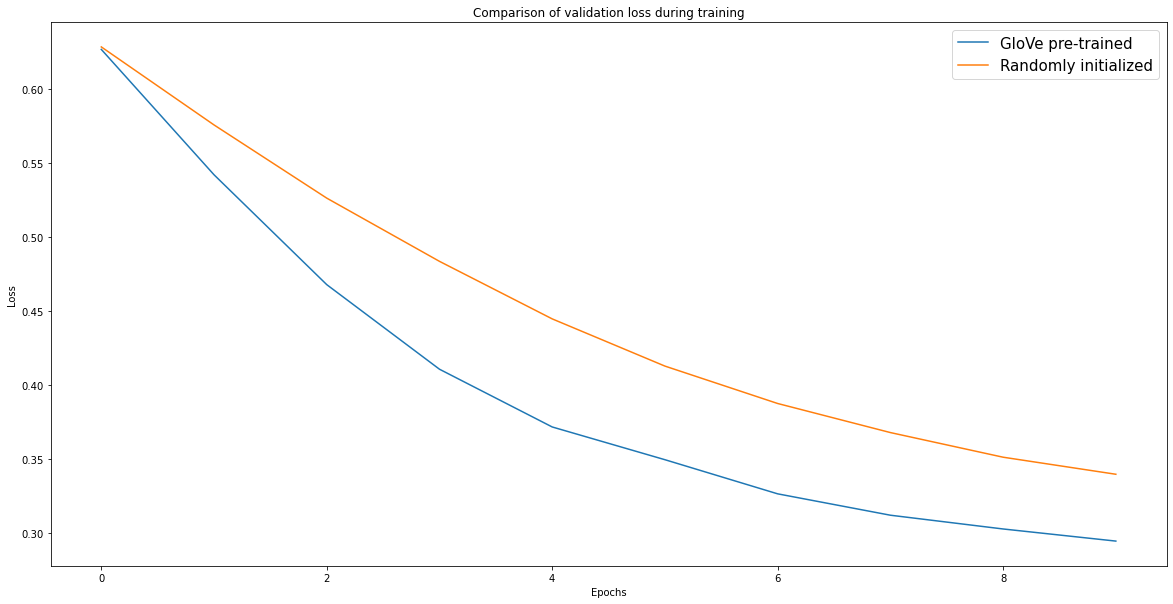

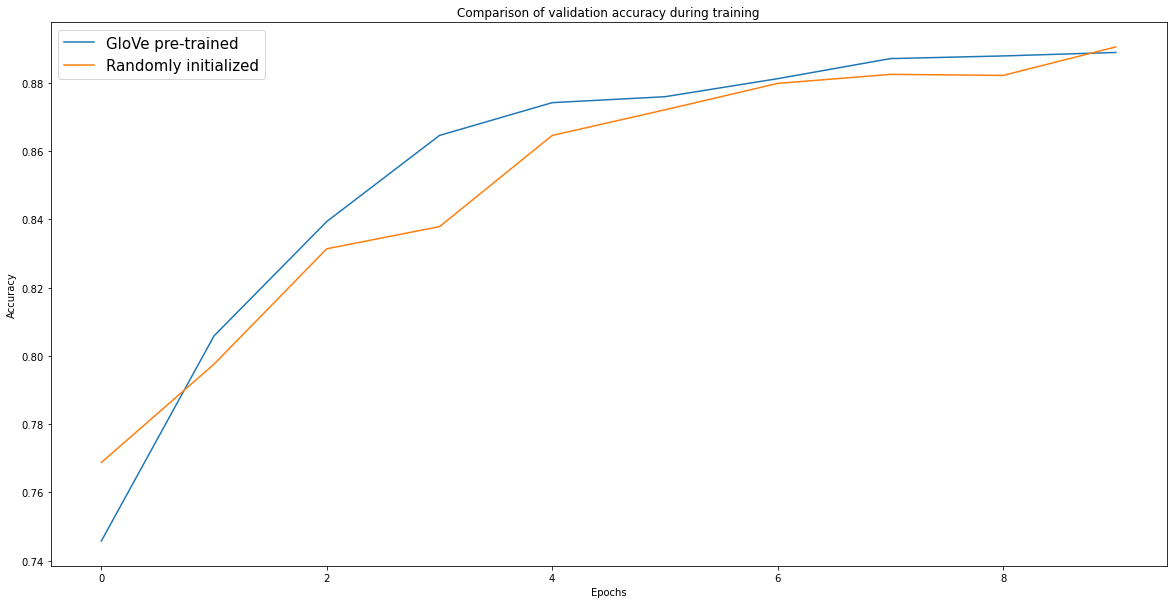

In [ ]:
# Let's compare the loss and accuracy values of the two models

plt.plot(pretr_valid_losses, label='GloVe pre-trained')
plt.plot(valid_losses, label='Randomly initialized')
plt.legend(fontsize=15)
plt.title('Comparison of validation loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(pretr_valid_accuracies, label='GloVe pre-trained')
plt.plot(valid_accuracies, label='Randomly initialized')
plt.legend(fontsize=15)
plt.title('Comparison of validation accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

As you can see, GloVe embeddings significantly outperform the randomly initialized ones. Can you guess why is that?

# Exercises

## Play with the training parameters
There is more than pre-trained weights that can change the outcome. Try to adjust some of the following parameters and report how this changes the outcome of your results:
* batch size of the iterators
* learning rate of the optimizer
* increasing the number of epochs
 
 _Note: do not forget to re-initialize your variables (most importantly dataloader, model, optimizer). To be on the safe-side, you can use different namings for these variables in every experiment_

In [ ]:
# your code here

## Pre-trained embeddings

Try to use different pre-trained embeddings than the ones shown in this lab. You can use different versions of GloVe or entirely new pre-trained vectors. You can check what is currently available [here](https://pytorch.org/text/stable/_modules/torchtext/vocab.html#Vocab.load_vectors).

In [ ]:
# your code here

## Improving the model (simple)

Let us try to improve our `SentimentAnalysisModel`.

In this exercise we took the mean of our embeddings after making a forward pass through the embedding layer. In practice, there is more efficient way by using an `torch.nn.EmbeddingBag` [link](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html#torch.nn.EmbeddingBag). This will make training faster and will also remove the need for taking the mean of the embeddings. Create a new class that contains the same layers as `SentimentAnalysisModel` but replacing the embedding layer with an embedding bag. Report if this changes the results in any way.

In [ ]:
# your code here

Another simple improvement you can perform is adding another linear layer after the embeddings and before the final fully connected one. Try this with different dimensionalities and report the differences.

In [ ]:
# your code here

## Improving the model (advanced)

These days, there are much more powerful components that researchers use instead of only embedding and linear layers. Recurrent Neural Networks (RNN) are one of the most popular ones. You can read about them here and specifically about PyTorch implementation [here](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). 

Try to improve your model by including a `torch.nn.RNN` module. Once this is working, you can also try a more sophisticated implementation, such as `torch.nn.LSTM` or `torch.nn.GRU`. You can experiment with the amount of layers and the bi-directionality. Practice shows that bi-directional RNNs usually perform better than uni-directional. Is this also valid for this model?

_More on recurrent layers in the next lab._

In [ ]:
# your code here